In [44]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)
import os
import sys
sys.path.insert(0, '../../src')
from utils import ProcessData
import unicodedata
from tqdm import tqdm
import re
import io
import msoffcrypto
from collections import OrderedDict, Counter
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from itertools import product
from googletrans import Translator
import googlemaps
from starlette.config import Config
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)
sns.set_style("white")
sns.set_style("ticks")
%matplotlib inline

translator = Translator()
config = Config("../../../../../.env")
pw = config("HASEKO_DATA_PW", cast=str)
google_api_key = config("HASEKO_GOOGLE_API_KEY", cast=str)
gmaps = googlemaps.Client(key=google_api_key)

norm_method = 'mean'

# Data processing

In [45]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def normalization(data,method):
    if method == 'mean':
        # Mean normalization
        x, y = data.mean(), data.std()
        data = (data-x)/y
    elif method == 'minmax':
        # Min-max normalization
        x, y = data.min(), data.max()
        data = (data-x)/(y-x)
    return data, (x.values[0],y.values[0])

def unskew_data(data):
    def process_data(data, idx):
        d = {}
        for i in data.columns:
            method = idx.loc[i,0]
            if method == 'Log':
                d[i] = np.log1p(data[i])
            elif method == 'Squared':
                d[i] = np.sqrt(data[i])
            else:
                d[i] = data[i]
        data_pr = pd.DataFrame(data=d, columns = data.columns)
        data_pr = data_pr.fillna(data_pr.mean())
        return data_pr
    
    data = data.astype(float)

    data_log = pd.DataFrame(np.log1p(data), columns= data.columns)
    data_square = pd.DataFrame(np.sqrt(data), columns= data.columns)

    data_skewness = pd.concat([data.skew(), data_log.skew(), data_square.skew()], axis=1)
    data_skewness.columns = ['Raw','Log','Squared']
    data_min = data_skewness.abs().idxmin(axis=1).to_frame()
    data_unskewed = process_data(data, data_min)
    
    return data_unskewed, data_min

# MF input shape

In [46]:
data_dir = '../data/コピーデータ240215_4回目.xls'
unlocked_file = io.BytesIO()

excel_file = msoffcrypto.OfficeFile(open(data_dir, "rb"))
excel_file.load_key(password = pw)
excel_file.decrypt(unlocked_file)
df = pd.read_excel(unlocked_file)

df.columns = [unicodedata.normalize('NFKC', s) for s in df.columns]
df.columns = [s+'\n'+str(translator.translate(s, dest='en').text) for s in df.columns]
df['年収\nAnnual income'] = [int(i)*100 for i in df['合算後年収.1\nAnnual income after the sum .1']]
# df['年収\nAnnual income'] = [int(re.sub(r'\D', '', i.replace('1000万円超','1200万円'))) for i in df['合算後年収\nAnnual income after the sum']]

print(df.shape)
df.head(1)

(6175, 13)


,NO\nNO,LP名\nLP name,実行年\nExecution,家族F\nFamily F,家族数\nFamily number,年齢\nage,合算後年収\nAnnual income after the sum,合算後年収.1\nAnnual income after the sum .1,借入金額(百万円単位)\nBorrowed amount (million yen units),"物件価格(千円)\nProperty price (1,000 yen)",面積\narea,最新住所\nLatest address,年収\nAnnual income
0,100001,マンション中心のLPの案件,2019,ファミリー,3,35,～1000万円,10,15,48000,65.01,さいたま市浦和区 上木崎 １－２－２４ クラッシィハウス浦和上木崎,1000


In [47]:
# address = df.loc[0,'最新住所\nLatest address']
# result = gmaps.geocode(address)
# lat = result[0]["geometry"]["location"]["lat"]
# lng = result[0]["geometry"]["location"]["lng"]
# print (lat,lng)

In [48]:
# Remove outlier in area column
df = remove_outliers(df, '面積\narea')
df_orig = df.copy()
print(df.shape)
df.head(1)

(5983, 13)


,NO\nNO,LP名\nLP name,実行年\nExecution,家族F\nFamily F,家族数\nFamily number,年齢\nage,合算後年収\nAnnual income after the sum,合算後年収.1\nAnnual income after the sum .1,借入金額(百万円単位)\nBorrowed amount (million yen units),"物件価格(千円)\nProperty price (1,000 yen)",面積\narea,最新住所\nLatest address,年収\nAnnual income
0,100001,マンション中心のLPの案件,2019,ファミリー,3,35,～1000万円,10,15,48000,65.01,さいたま市浦和区 上木崎 １－２－２４ クラッシィハウス浦和上木崎,1000


In [49]:
# Remove unique address
cnt = Counter(df['最新住所\nLatest address'])
cnt = {k:v for k,v in cnt.items() if v==1}
df = df[~df['最新住所\nLatest address'].isin(list(cnt.keys()))]
print(df.shape)
df.head(1)

(5656, 13)


,NO\nNO,LP名\nLP name,実行年\nExecution,家族F\nFamily F,家族数\nFamily number,年齢\nage,合算後年収\nAnnual income after the sum,合算後年収.1\nAnnual income after the sum .1,借入金額(百万円単位)\nBorrowed amount (million yen units),"物件価格(千円)\nProperty price (1,000 yen)",面積\narea,最新住所\nLatest address,年収\nAnnual income
0,100001,マンション中心のLPの案件,2019,ファミリー,3,35,～1000万円,10,15,48000,65.01,さいたま市浦和区 上木崎 １－２－２４ クラッシィハウス浦和上木崎,1000


In [50]:
# Remove duplicate properties
df = df.drop_duplicates(subset=['物件価格(千円)\nProperty price (1,000 yen)', '面積\narea', '最新住所\nLatest address'])
print(df.shape)
df.head(1)

(4464, 13)


,NO\nNO,LP名\nLP name,実行年\nExecution,家族F\nFamily F,家族数\nFamily number,年齢\nage,合算後年収\nAnnual income after the sum,合算後年収.1\nAnnual income after the sum .1,借入金額(百万円単位)\nBorrowed amount (million yen units),"物件価格(千円)\nProperty price (1,000 yen)",面積\narea,最新住所\nLatest address,年収\nAnnual income
0,100001,マンション中心のLPの案件,2019,ファミリー,3,35,～1000万円,10,15,48000,65.01,さいたま市浦和区 上木崎 １－２－２４ クラッシィハウス浦和上木崎,1000


In [51]:
df_test = df.copy()
print(df_test.shape)
df_test = df_test[df_test['年収\nAnnual income']>=800]
df_test = df_test[df_test['年収\nAnnual income']<=1200]
print(df_test.shape)
df_test = df_test[df_test['物件価格(千円)\nProperty price (1,000 yen)']>=40000]
df_test = df_test[df_test['物件価格(千円)\nProperty price (1,000 yen)']<=50000]
print(df_test.shape)
df_test = df_test[df_test['家族F\nFamily F']=='ファミリー']
print(df_test.shape)
df_test = df_test[df_test['面積\narea']>=45]
print(df_test.shape)

(4464, 13)
(1824, 13)
(607, 13)
(206, 13)
(205, 13)


# Visualization before and after processing

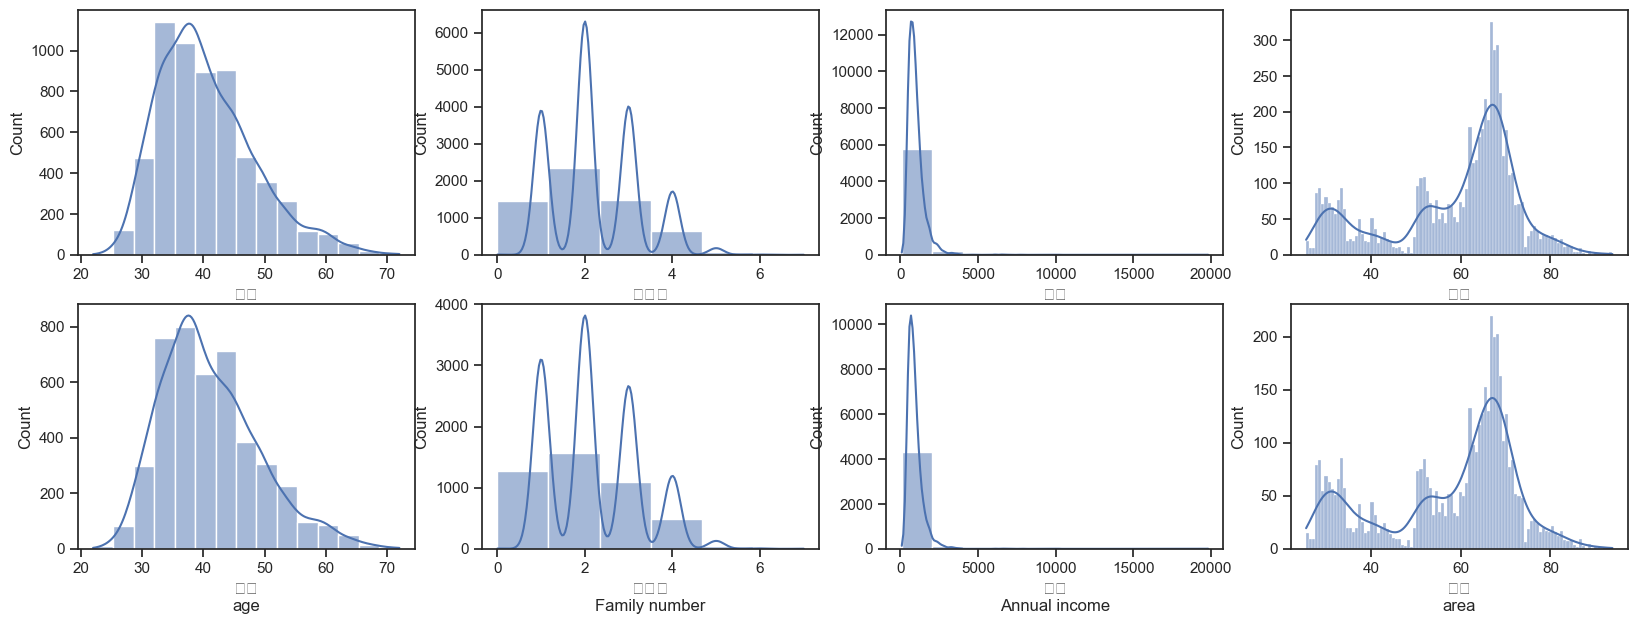

In [52]:
fig,axes = plt.subplots(2, 4, figsize=(20, 7))
sns.histplot(df_orig['年齢\nage'], ax=axes[0,0], kde=True, bins=15)
sns.histplot(df_orig['家族数\nFamily number'], ax=axes[0,1], kde=True, bins=6)
sns.histplot(df_orig['年収\nAnnual income'], ax=axes[0,2], kde=True, bins=10)
sns.histplot(df_orig['面積\narea'], ax=axes[0,3], kde=True, bins=100)

sns.histplot(df['年齢\nage'], ax=axes[1,0], kde=True, bins=15)
sns.histplot(df['家族数\nFamily number'], ax=axes[1,1], kde=True, bins=6)
sns.histplot(df['年収\nAnnual income'], ax=axes[1,2], kde=True, bins=10)
sns.histplot(df['面積\narea'], ax=axes[1,3], kde=True, bins=100)

sns.set_style("white")
sns.set(font_scale=1.0, font="MS Gothic")
plt.show()

# Comparison with previous training data

In [53]:
base_params = '../../src/params'
base_data = '../../haseko_v0/data/mansionfit_2020-12-02.csv'

data = ProcessData()
params_ml, _, area_data = data.load_json_file(base_params)
pws, _, _ = data.create_user_buildings_df(base_data, area_data)
pws = pws.dropna(axis=0)
pws['family_members'] = pws['family_members'].astype(int)
pws['income'] /= 10000

print(pws.shape)
pws.head(1)

(5487, 54)


,id_x,user_id,building_id,price,width,floor_plan,age,income,family_members,kids_members,current_rent,home_pref_code,home_pref_name,home_city_code,home_city_name,home_area_code,home_area_name,home_search_area_code,home_search_area_name,office_pref_code,office_pref_name,office_city_code,office_city_name,office_area_code,office_area_name,office_search_area_code,office_search_area_name,mf_price_type,mf_age_type,mf_income_type,mf_family_type,mf_floor_plan_type,mf_price_type_str,mf_age_type_str,mf_income_type_str,mf_family_type_str,mf_floor_plan_type_str,id_y,name,pref_code,pref_name,city_code,city_name,area_code,area_name,search_area_code,search_area_name,lon,lat,station_line_code,station_code,station_lon,station_lat,mf_id
0,31110031-3058098-01,3058098,31110031-31110031,55899100,70.56,3LDK,53.0,1500.0,5,3.0,180000.0,13.0,東京都,13117.0,北区,1303.0,東京東部,1303.0,東京23区東エリア,13.0,東京都,13104.0,新宿区,1301.0,東京中央,1301.0,東京23区中央エリア,5000,45.0,1500,2,4.0,5000万台,45歳以上,1500万〜,パートナーと子供,3LDK,31110031-31110031,ザ・ガーデンズ東京王子,13,東京都,13117,北区,1303,東京東部,1303,東京23区東エリア,139.726858,35.763803,11332.0,1133211.0,35.763803,139.726858,a-1


In [54]:
df_test = pws.copy()
print(df_test.shape)
df_test = df_test[df_test['income']>=800]
df_test = df_test[df_test['income']<=1200]
print(df_test.shape)
df_test = df_test[df_test['price']>=40000]
df_test = df_test[df_test['price']<=50000]
print(df_test.shape)
df_test = df_test[df_test['mf_family_type_str']=='パートナーと子供']
print(df_test.shape)
df_test = df_test[df_test['width']>=45]
print(df_test.shape)

(5487, 54)
(1815, 54)
(0, 54)
(0, 54)
(0, 54)


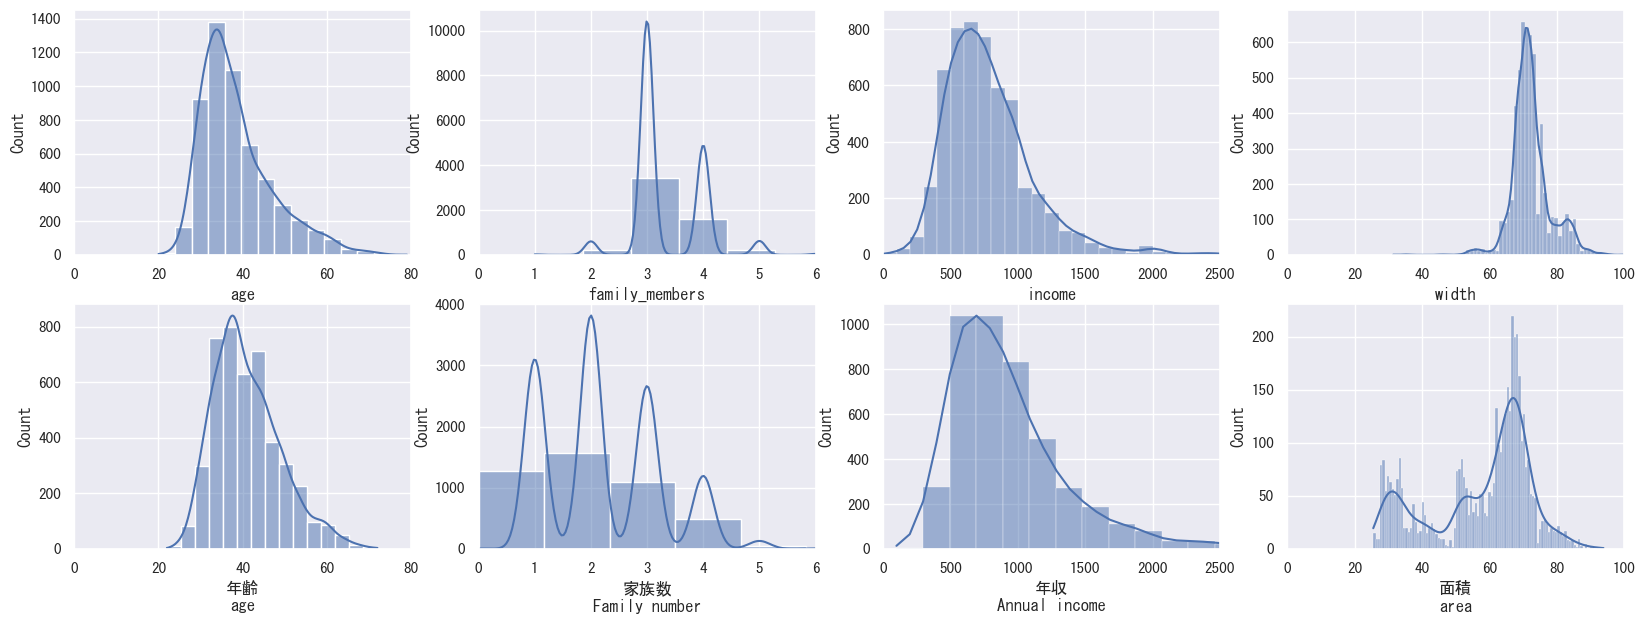

In [55]:
fig, axes = plt.subplots(2, 4, figsize=(20, 7))
sns.histplot(pws['age'], ax=axes[0,0], kde=True, bins=15)
axes[0,0].set_xlim(0, 80)
sns.histplot(pws['family_members'], ax=axes[0,1], kde=True, bins=7)
axes[0,1].set_xlim(0, 6)
sns.histplot(pws['income'], ax=axes[0,2], kde=True, bins=100)
axes[0,2].set_xlim(0, 2500)
sns.histplot(pws['width'], ax=axes[0,3], kde=True, bins=100)
axes[0,3].set_xlim(0, 100)

sns.histplot(df['年齢\nage'], ax=axes[1,0], kde=True, bins=15)
axes[1,0].set_xlim(0, 80)
sns.histplot(df['家族数\nFamily number'], ax=axes[1,1], kde=True, bins=6)
axes[1,1].set_xlim(0, 6)
sns.histplot(df['年収\nAnnual income'], ax=axes[1,2], kde=True, bins=100)
axes[1,2].set_xlim(0, 2500)
sns.histplot(df['面積\narea'], ax=axes[1,3], kde=True, bins=100)
axes[1,3].set_xlim(0, 100)

sns.set_style("white")
sns.set(font_scale=1.0, font="MS Gothic")
plt.show()

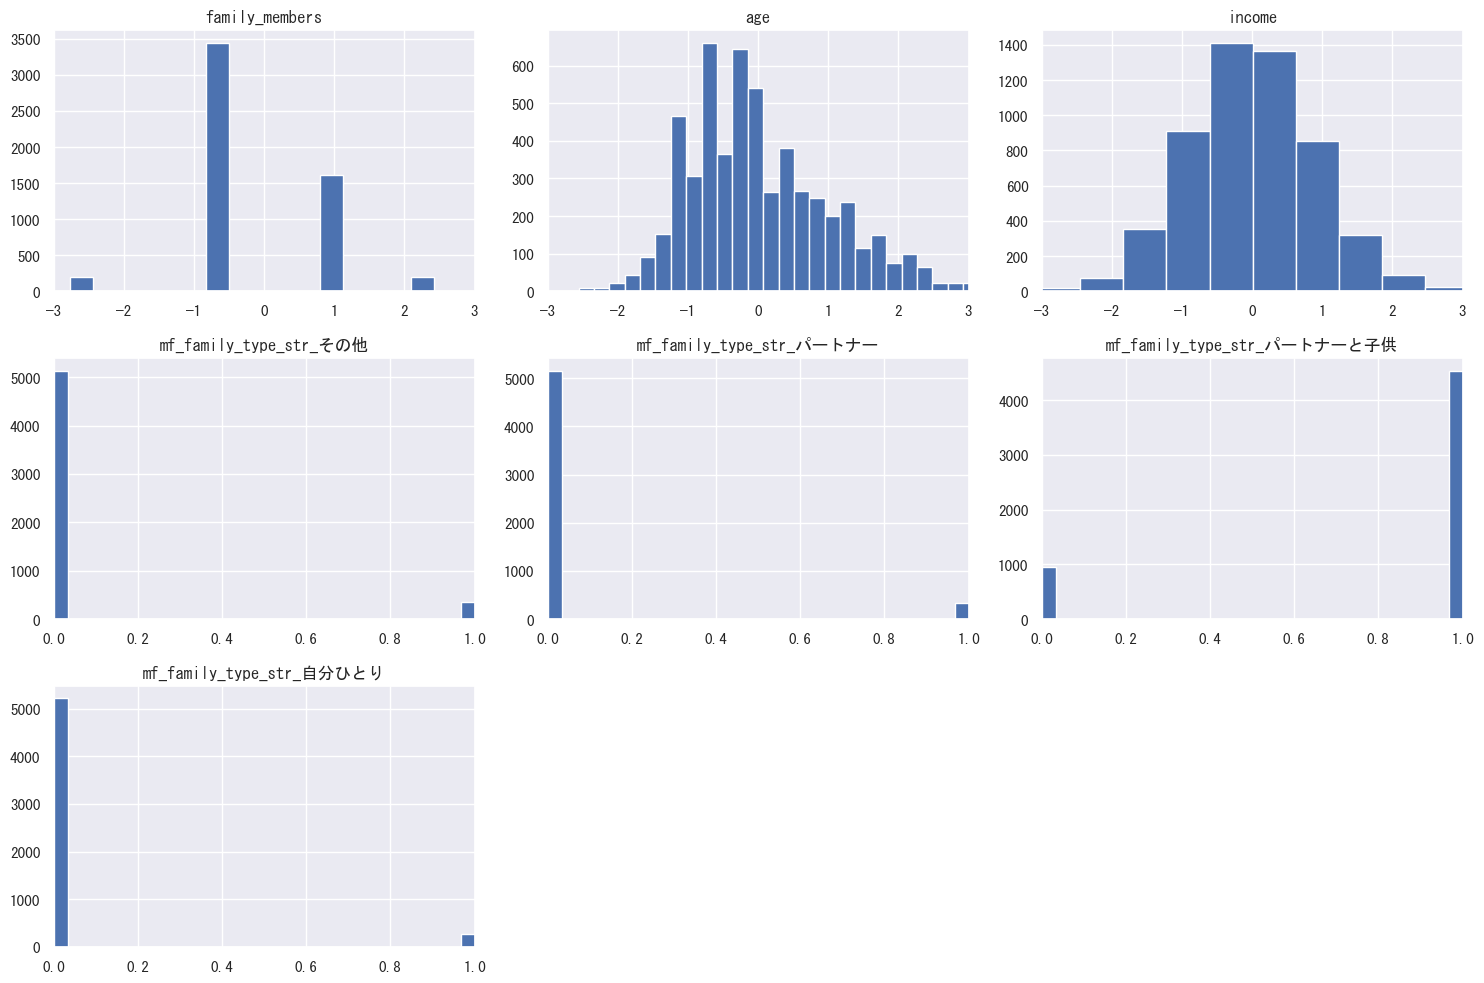

In [59]:
continuous_col = ['family_members','age','income']
categorical_col = ['mf_family_type_str']
data_continuous, transform_input = unskew_data(pws[continuous_col])
data_continuous, (x_in, y_in) = normalization(data_continuous, norm_method)

encoder = OneHotEncoder(dtype=np.int64, sparse=True)
data_categorical = pd.DataFrame(encoder.fit_transform(pws[categorical_col]).toarray(),
                                columns = [i for i in encoder.get_feature_names_out()],
                                index = pws.index)

data_before = pd.concat([data_continuous, data_categorical], axis=1)
sns.set(font_scale=1.0, font="MS Gothic")
axes = data_before.hist(bins=30, figsize=(15, 10))

# Specify x-axis limits for each histogram
xlims = [(-3, 3), (-3, 3), (-3, 3), (0, 1), (0, 1), (0, 1), (0, 1)]  # Example limits for columns A, B, and C
for ax, xlim in zip(axes.flatten(), xlims):
    ax.set_xlim(xlim)
plt.tight_layout()
plt.show()

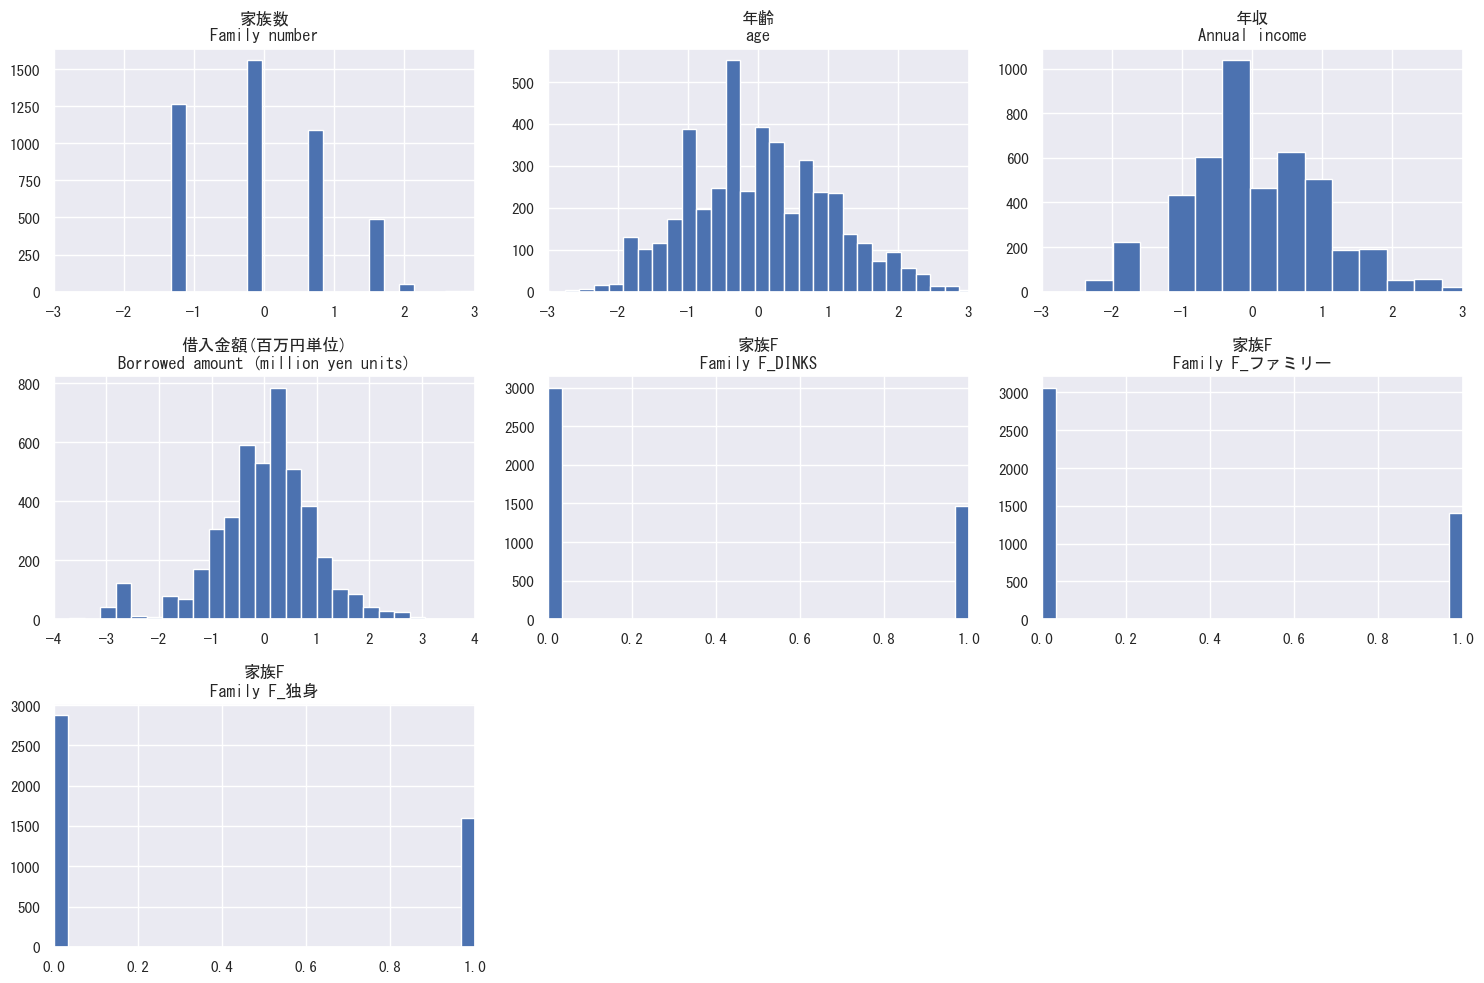

In [60]:
continuous_col = ['家族数\nFamily number','年齢\nage','年収\nAnnual income','借入金額(百万円単位)\nBorrowed amount (million yen units)']
categorical_col = ['家族F\nFamily F'] 
data_continuous, transform_input = unskew_data(df[continuous_col])
data_continuous, (x_in, y_in) = normalization(data_continuous, norm_method)

encoder = OneHotEncoder(dtype=np.int64, sparse=True)
data_categorical = pd.DataFrame(encoder.fit_transform(df[categorical_col]).toarray(),
                                columns = [i for i in encoder.get_feature_names_out()],
                                index = df.index)

data_after = pd.concat([data_continuous, data_categorical], axis=1)
sns.set(font_scale=1.0, font="MS Gothic")
axes = data_after.hist(bins=30, figsize=(15, 10))

# Specify x-axis limits for each histogram
xlims = [(-3, 3), (-3, 3), (-3, 3), (-4, 4), (0, 1), (0, 1), (0, 1)]  # Example limits for columns A, B, and C
for ax, xlim in zip(axes.flatten(), xlims):
    ax.set_xlim(xlim)
plt.tight_layout()
plt.show()

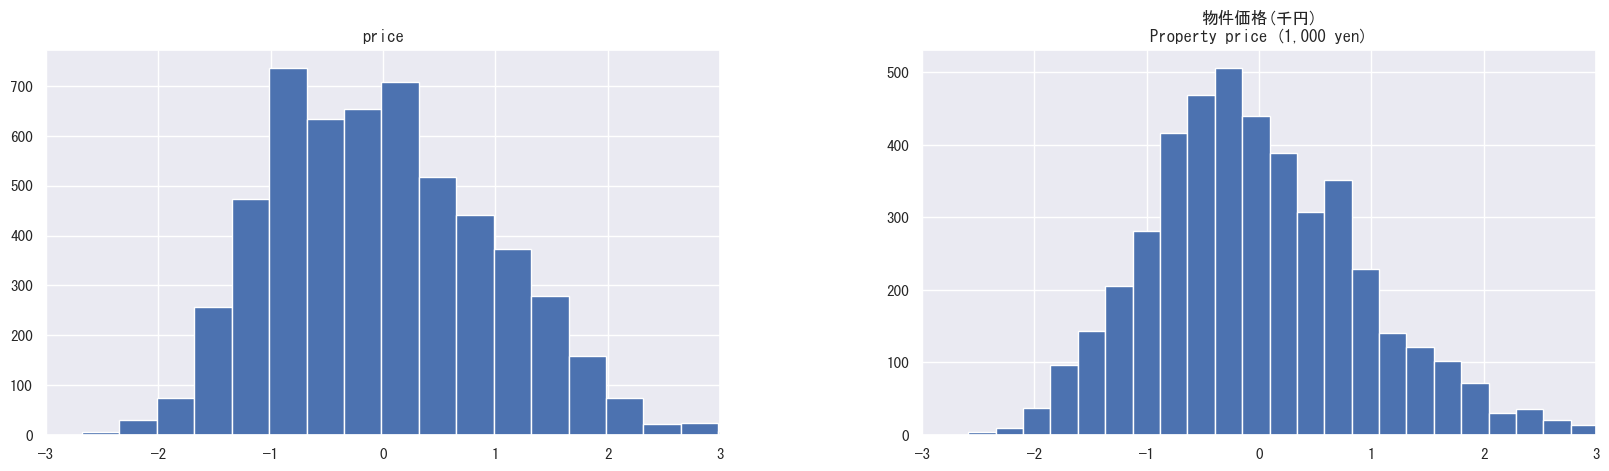

In [61]:
target_before, _ = unskew_data(pws[['price']])
target_before, _ = normalization(target_before, norm_method)

target_after, _ = unskew_data(df[['物件価格(千円)\nProperty price (1,000 yen)']])
target_after, _ = normalization(target_after, norm_method)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
target_before.hist(bins=30, ax=ax1)
ax1.set_xlim(-3, 3)
target_after.hist(bins=30, ax=ax2)
ax2.set_xlim(-3, 3)
plt.show()